## Cross-Check with AM

Text(0, 0.5, '$\\tau$ [nepers]')

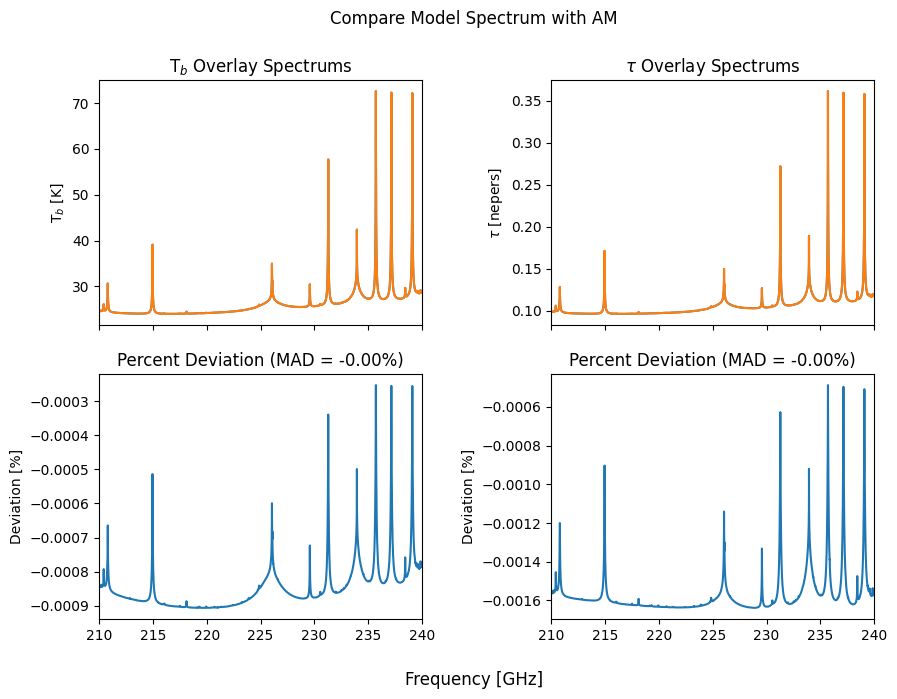

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)
data = my_ozone.data
freq_range = (210, 240)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

start_logairmass = 0.001
start_logNscale = -2.0

second_logairmass = 0.041
second_logNscale = -1.875

end_logairmass = 1.281
end_logNscale = 2.0

interval_logairmass = np.abs(second_logairmass-start_logairmass)
interval_logNscale = np.abs(second_logNscale - start_logNscale)

width_logairmass = int((end_logairmass - start_logairmass)/interval_logairmass)+1
width_logNscale = int((end_logNscale - start_logNscale)/interval_logNscale)+1

map_logairmass = np.linspace(start_logairmass, end_logairmass, width_logairmass)
map_logNscale = np.linspace(start_logNscale, end_logNscale, width_logNscale)

########################################################

logairmass = 0.001
logNscale = 0.125
filename = f'MaunaKea_Tb_Spectrum_{logairmass:.3f}_{logNscale:+.3f}'
data = np.load(f'{my_ozone.am_model_data_path}{filename}.out')
Tb_data = data[:,4]
tau_data = data[:,1]

zenith_angle = my_ozone._airmass_to_zenith(np.exp(logairmass))
pwv = (np.exp(logNscale))*my_ozone.nominal_pwv

fig, ax = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(10, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
j=0
for model_spectrum, expected_spectrum in zip(my_ozone(pwv, zenith_angle, return_opacity_pair=True), [Tb_data, tau_data]):
    difference_spectrum = ((model_spectrum[freq_mask] - expected_spectrum[freq_mask]) / expected_spectrum[freq_mask]) * 100

    ax[0][j].plot(freq_channels[freq_mask], expected_spectrum[freq_mask])
    ax[0][j].plot(freq_channels[freq_mask], model_spectrum[freq_mask])
    ax[1][j].plot(freq_channels[freq_mask], difference_spectrum)

    fig.supxlabel("Frequency [GHz]")
    fig.suptitle("Compare Model Spectrum with AM")

    percentile_50, percentile_99 = np.percentile(difference_spectrum, [50, 99])
    ax[1][j].set_title(f"Percent Deviation (MAD = {percentile_50:.2f}%)")
    ax[1][j].set_ylabel('Deviation [%]')
    ax[1][j].set_xlim(min(freq_channels[freq_mask]), max(freq_channels[freq_mask]));
    j+=1
ax[0][0].set_title(r"T$_b$ Overlay Spectrums")
ax[0][1].set_title(r"$\tau$ Overlay Spectrums")
ax[0][0].set_ylabel(r'T$_b$ [K]')
ax[0][1].set_ylabel(r'$\tau$ [nepers]')

## PWV Jacobian Sum

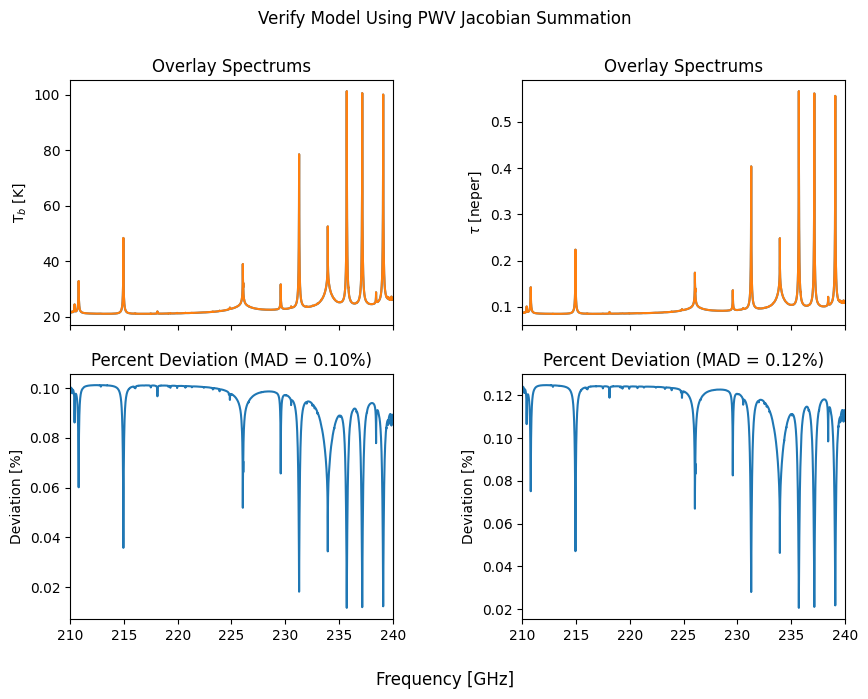

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)

freq_range = (210, 240)
#freq_range = (180, 420)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

nscale_map = my_ozone.data['Nscale']['map']
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * np.exp(nscale_map)

start_pwv=pwv_map[0] #start_pwv=4
end_pwv=pwv_map[1] #end_pwv=5
zenith_angle=1
points=100

test_pwv_map = np.linspace(start_pwv, end_pwv, points)

fig, ax = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(10, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
j=0
for base_spectrum, expected_spectrum in zip(my_ozone(start_pwv, zenith_angle, return_opacity_pair=True),
                                            my_ozone(end_pwv, zenith_angle, return_opacity_pair=True)):

    test_spectrum = base_spectrum[freq_mask]
    for pwv in test_pwv_map:
        pwv_jacobian = my_ozone(pwv, zenith_angle, return_pwv_jacobian=True, 
                                return_model_spectrum=False, return_opacity_pair=True)
        pwv_jacobian = pwv_jacobian[j][freq_mask]   # Select from [Tb,tau]
        little_jacobian = pwv_jacobian * ((end_pwv-start_pwv)/points)
        test_spectrum += little_jacobian

    difference_spectrum = abs((test_spectrum - expected_spectrum[freq_mask]) / expected_spectrum[freq_mask]) * 100

    ax[0][j].plot(freq_channels[freq_mask], expected_spectrum[freq_mask])
    ax[0][j].plot(freq_channels[freq_mask], test_spectrum)
    ax[1][j].plot(freq_channels[freq_mask], difference_spectrum)

    fig.supxlabel("Frequency [GHz]")
    fig.suptitle("Verify Model Using PWV Jacobian Summation")

    ax[0][j].set_title(f"Overlay Spectrums")
    ax[0][j].set_ylabel(r'T$_b$ [K]')

    mad_deviation, percentile_99 = np.percentile(difference_spectrum, [50, 99])
    # 50th percentile of % difference spectrum is equal to np.median(np.abs(difference_spectrum))
    # Median absolute difference

    ax[1][j].set_title(f"Percent Deviation (MAD = {mad_deviation:.2f}%)")
    ax[1][j].set_ylabel('Deviation [%]')
    ax[1][j].set_xlim(min(freq_channels[freq_mask]), max(freq_channels[freq_mask]))
    j+=1

ax[0][0].set_ylabel(r'T$_b$ [K]')
ax[0][1].set_ylabel(r'$\tau$ [neper]');

## PWV Jacobian Sum Map

Text(0.5, 1.0, 'Difference Spectrum')

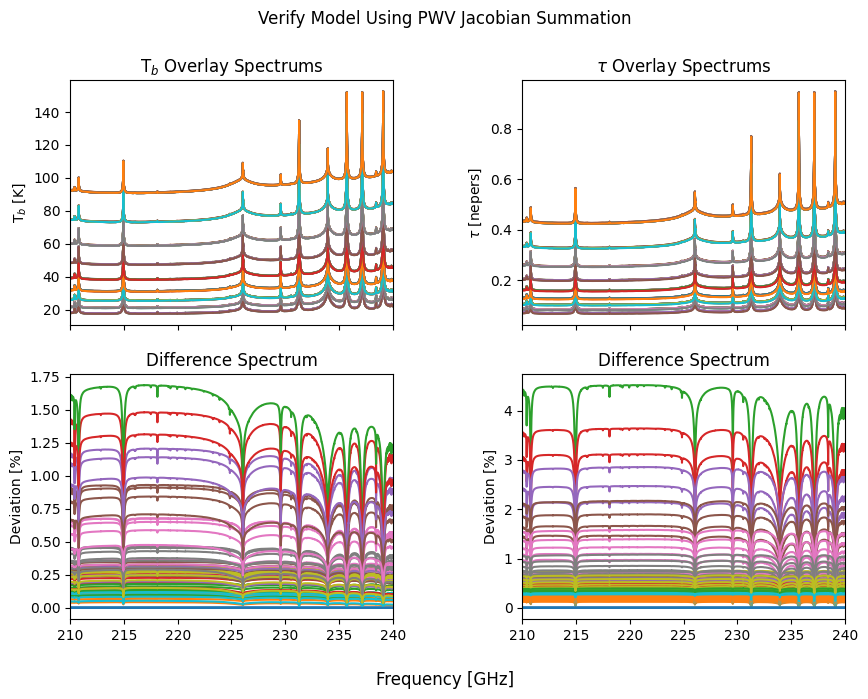

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)

freq_range = (210, 240)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

nscale_map = my_ozone.data['Nscale']['map']
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * np.exp(nscale_map)

zenith_angle=1
points=100

fig, ax = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(10, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

jac_results_MAD = np.zeros((2, len(pwv_map), len(pwv_map)), dtype=float)
jac_results_max = np.zeros((2, len(pwv_map), len(pwv_map)), dtype=float)

for idx, start_pwv in enumerate(pwv_map):
    for jdx, end_pwv in enumerate(pwv_map):
            test_pwv_map = np.linspace(start_pwv, end_pwv, points)
            
            i=0
            for base_spectrum, expected_spectrum in zip(my_ozone(start_pwv, zenith_angle, return_opacity_pair=True),
                                            my_ozone(end_pwv, zenith_angle, return_opacity_pair=True)):
                test_spectrum = base_spectrum[freq_mask]
                for pwv in test_pwv_map:
                    pwv_jacobian = my_ozone(pwv, zenith_angle, return_pwv_jacobian=True, 
                                            return_model_spectrum=False, return_opacity_pair=True)
                    pwv_jacobian = pwv_jacobian[i%2][freq_mask]   # Select from [Tb,tau]
                    little_jacobian = pwv_jacobian * ((end_pwv-start_pwv)/points)
                    test_spectrum += little_jacobian

                difference_spectrum = abs((test_spectrum - expected_spectrum[freq_mask]) / expected_spectrum[freq_mask]) * 100

                percentile_50, percentile_99 = np.percentile(difference_spectrum, [50, 99])
                jac_results_MAD[i%2, idx, jdx] = percentile_50
                jac_results_max[i%2, idx, jdx] = percentile_99

                ax[0][i%2].plot(freq_channels[freq_mask], expected_spectrum[freq_mask])
                ax[0][i%2].plot(freq_channels[freq_mask], test_spectrum)
                ax[1][i%2].plot(freq_channels[freq_mask], difference_spectrum)
                ax[1][i%2].set_xlim(min(freq_channels[freq_mask]), max(freq_channels[freq_mask]))
                ax[1][i%2].set_ylabel('Deviation [%]')
                i+=1

fig.supxlabel("Frequency [GHz]")
fig.suptitle("Verify Model Using PWV Jacobian Summation")
ax[0][0].set_ylabel(r'T$_b$ [K]')
ax[0][1].set_ylabel(r'$\tau$ [nepers]')
ax[0][0].set_title(r"T$_b$ Overlay Spectrums")
ax[0][1].set_title(r"$\tau$ Overlay Spectrums")
ax[1][0].set_title(f"Difference Spectrum")
ax[1][1].set_title(f"Difference Spectrum")

Text(0.5, 1.0, '$\\tau$')

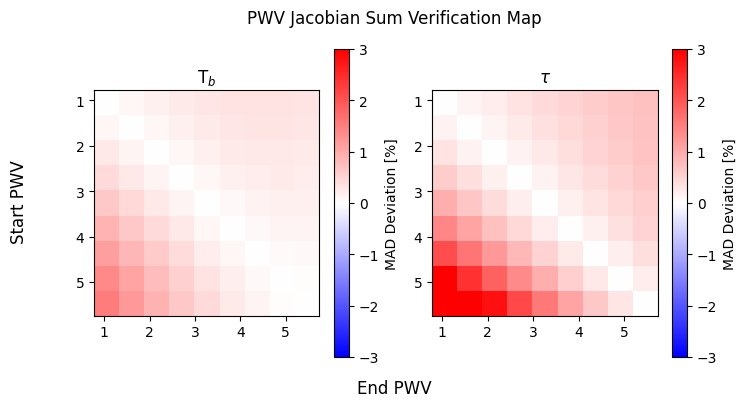

In [36]:
import matplotlib.colors as colors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

vmin = -3
vmax = 3
norm = colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

map_extent = [pwv_map[0], pwv_map[-1], pwv_map[-1], pwv_map[0]]

for a, results in zip(axs, jac_results_MAD):
    im = a.imshow(results, cmap='bwr', norm=norm, extent=map_extent, aspect='equal')
    fig.colorbar(im, ax=a, label='MAD Deviation [%]')

fig.supylabel('Start PWV')
fig.supxlabel('End PWV')
fig.suptitle('PWV Jacobian Sum Verification Map')

axs[0].set_title(r'T$_b$')
axs[1].set_title(r'$\tau$')
#plt.clim(-3, 0)

## ZA Jacobian Sum

Text(0, 0.5, '$\\tau$ [neper]')

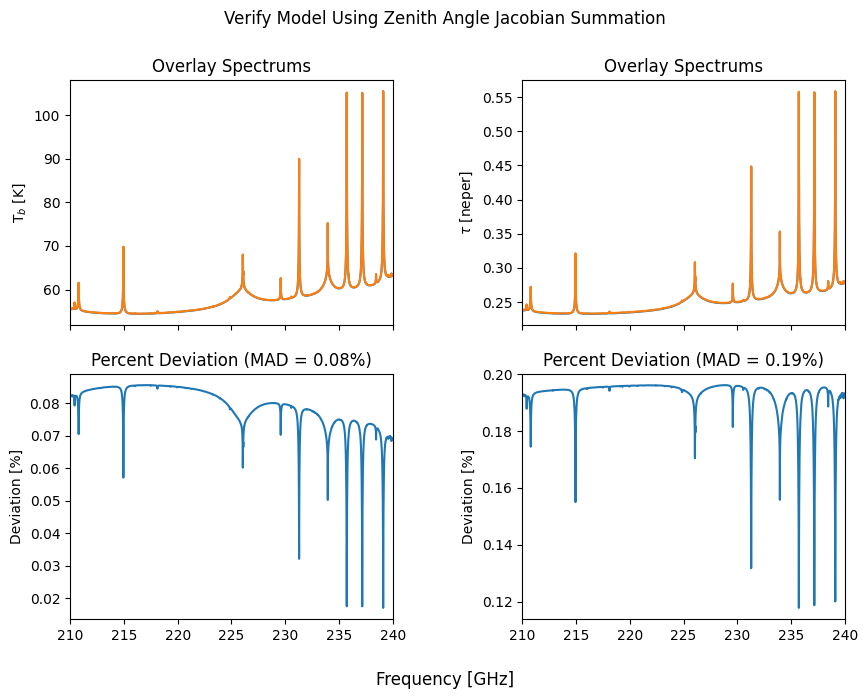

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)

freq_range = (210, 240)
#freq_range = (180, 420)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

airmass_map = np.exp(my_ozone.data['airmass']['map'])
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
start_zenith=zenith_map[0] #start_zenith=0.2
end_zenith=zenith_map[1] #end_zenith=0.4
pwv=5
points=100

zenith_map = np.linspace(start_zenith, end_zenith, points)

fig, ax = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(10, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
j=0
for base_spectrum, expected_spectrum in zip(my_ozone(pwv, start_zenith, return_opacity_pair=True),
                                            my_ozone(pwv, end_zenith, return_opacity_pair=True)):
    
    test_spectrum = base_spectrum[freq_mask]
    for zenith in zenith_map:
        zenith_jacobian = my_ozone(pwv, zenith, return_zenith_jacobian=True, 
                                   return_model_spectrum=False, return_opacity_pair=True)
        zenith_jacobian = zenith_jacobian[j][freq_mask]
        little_jacobian = zenith_jacobian * ((end_zenith-start_zenith)/points)
        test_spectrum += little_jacobian

    difference_spectrum = abs((test_spectrum - expected_spectrum[freq_mask]) / expected_spectrum[freq_mask]) * 100

    ax[0][j].plot(freq_channels[freq_mask], expected_spectrum[freq_mask])
    ax[0][j].plot(freq_channels[freq_mask], test_spectrum)
    ax[1][j].plot(freq_channels[freq_mask], difference_spectrum)

    fig.supxlabel("Frequency [GHz]")
    fig.suptitle("Verify Model Using Zenith Angle Jacobian Summation")


    ax[0][j].set_title(f"Overlay Spectrums")

    percentile_50, percentile_99 = np.percentile(difference_spectrum, [50, 99])
    ax[1][j].set_title(f"Percent Deviation (MAD = {percentile_50:.2f}%)")
    ax[1][j].set_ylabel('Deviation [%]')
    ax[1][j].set_xlim(min(freq_channels[freq_mask]), max(freq_channels[freq_mask]));
    j+=1

ax[0][0].set_ylabel(r'T$_b$ [K]')
ax[0][1].set_ylabel(r'$\tau$ [neper]')

## ZA Jacobian Sum Map

Text(0.5, 1.0, 'Difference Spectrum')

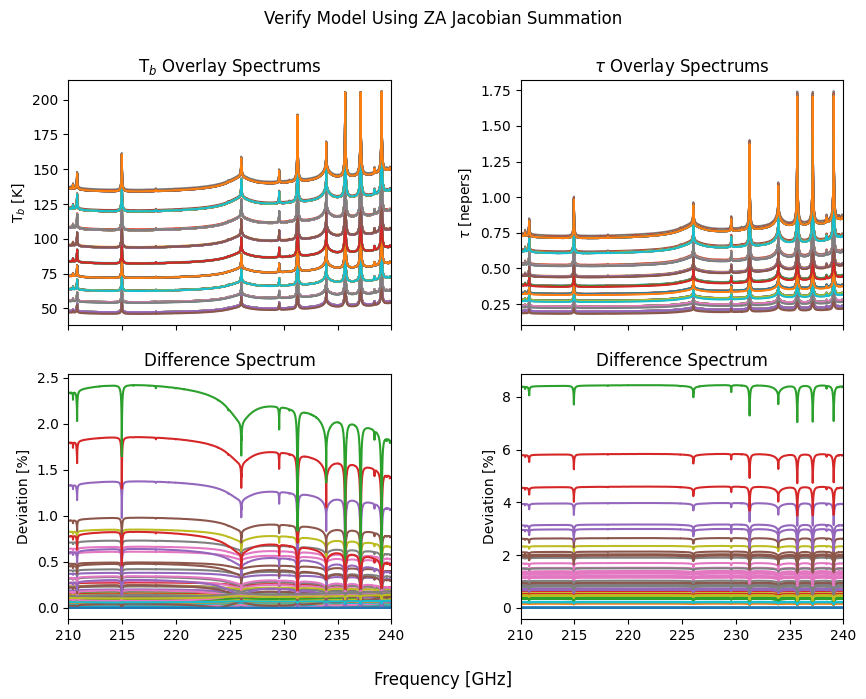

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)

freq_range = (210, 240)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

airmass_map = np.exp(my_ozone.data['airmass']['map'])
zenith_map = my_ozone._airmass_to_zenith(airmass_map)

pwv=5
points=100

fig, ax = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(10, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

jac_results_MAD = np.zeros((2, len(pwv_map), len(pwv_map)), dtype=float)
jac_results_max = np.zeros((2, len(pwv_map), len(pwv_map)), dtype=float)

for idx, start_zenith in enumerate(zenith_map):
    for jdx, end_zenith in enumerate(zenith_map):
            test_zenith_map = np.linspace(start_zenith, end_zenith, points)

            i=0
            for base_spectrum, expected_spectrum in zip(my_ozone(pwv, start_zenith, return_opacity_pair=True),
                                            my_ozone(pwv, end_zenith, return_opacity_pair=True)):
    
                test_spectrum = base_spectrum[freq_mask]
                for zenith in test_zenith_map:
                    zenith_jacobian = my_ozone(pwv, zenith, return_zenith_jacobian=True, 
                                            return_model_spectrum=False, return_opacity_pair=True)
                    zenith_jacobian = zenith_jacobian[i%2][freq_mask]   # Select from [Tb, tau]
                    little_jacobian = zenith_jacobian * ((end_zenith-start_zenith)/points)
                    test_spectrum += little_jacobian

                difference_spectrum = abs((test_spectrum - expected_spectrum[freq_mask]) / expected_spectrum[freq_mask]) * 100

                mad_deviation, max_deviation = np.percentile(difference_spectrum, [50, 99])
                jac_results_MAD[i%2, idx, jdx] = mad_deviation
                jac_results_max[i%2, idx, jdx] = max_deviation

                ax[0][i%2].plot(freq_channels[freq_mask], expected_spectrum[freq_mask])
                ax[0][i%2].plot(freq_channels[freq_mask], test_spectrum)
                ax[1][i%2].plot(freq_channels[freq_mask], difference_spectrum)
                ax[1][i%2].set_xlim(min(freq_channels[freq_mask]), max(freq_channels[freq_mask]))
                ax[1][i%2].set_ylabel('Deviation [%]')
                i+=1

fig.supxlabel("Frequency [GHz]")
fig.suptitle("Verify Model Using ZA Jacobian Summation")
ax[0][0].set_ylabel(r'T$_b$ [K]')
ax[0][1].set_ylabel(r'$\tau$ [nepers]')
ax[0][0].set_title(r"T$_b$ Overlay Spectrums")
ax[0][1].set_title(r"$\tau$ Overlay Spectrums")
ax[1][0].set_title(f"Difference Spectrum")
ax[1][1].set_title(f"Difference Spectrum")

Text(0.5, 1.0, '$\\tau$')

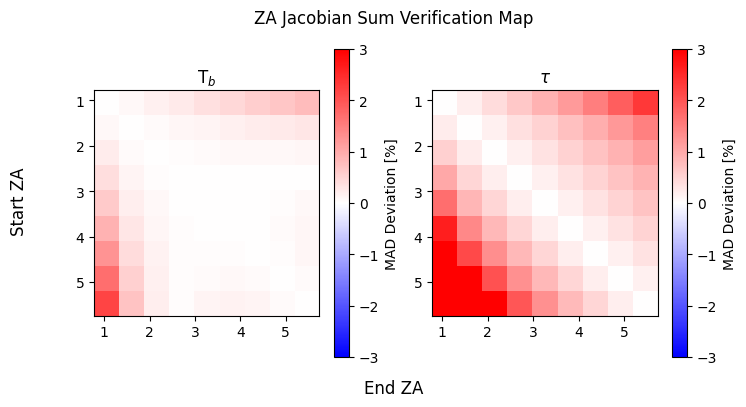

In [38]:
import matplotlib.colors as colors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

vmin = -3
vmax = 3
norm = colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

map_extent = [pwv_map[0], pwv_map[-1], pwv_map[-1], pwv_map[0]]

for a, results in zip(axs, jac_results_MAD):
    im = a.imshow(results, cmap='bwr', norm=norm, extent=map_extent, aspect='equal')
    fig.colorbar(im, ax=a, label='MAD Deviation [%]')

fig.supylabel('Start ZA')
fig.supxlabel('End ZA')
fig.suptitle('ZA Jacobian Sum Verification Map')

axs[0].set_title(r'T$_b$')
axs[1].set_title(r'$\tau$')
#plt.clim(-3, 0)

# Midpoints

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)
data = my_ozone.data
freq_channels = my_ozone.data['freq']['map']

start_logairmass = 0.001
start_logNscale = -2.0

second_logairmass = 0.041
second_logNscale = -1.875

end_logairmass = 1.281
end_logNscale = 2.0

interval_logairmass = np.abs(second_logairmass-start_logairmass)
interval_logNscale = np.abs(second_logNscale - start_logNscale)

width_logairmass = int((end_logairmass - start_logairmass)/interval_logairmass)+1
width_logNscale = int((end_logNscale - start_logNscale)/interval_logNscale)+1

map_logairmass = np.linspace(start_logairmass, end_logairmass, width_logairmass)
map_logNscale = np.linspace(start_logNscale, end_logNscale, width_logNscale)

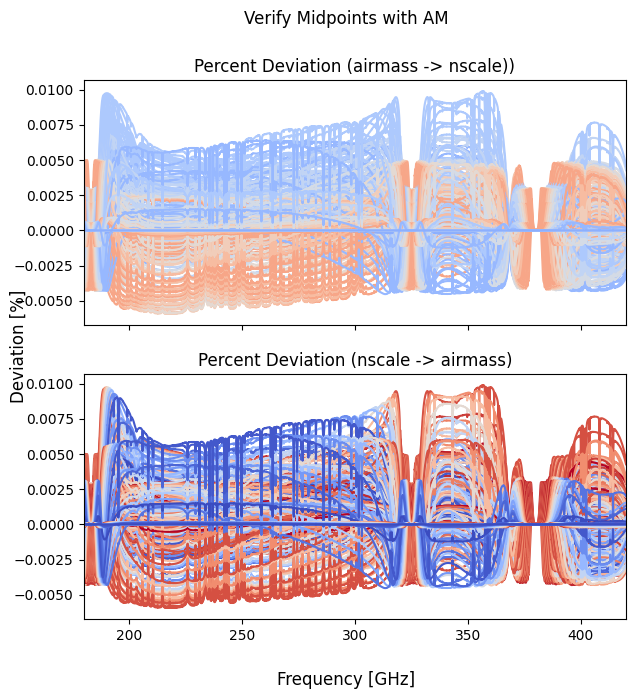

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

num_lines = map_logNscale.size
x = np.linspace(0, 10, num_lines)

cmap = plt.get_cmap('coolwarm_r')  # or 'plasma', 'coolwarm', 'inferno', etc.
norm = mcolors.Normalize(vmin=0, vmax=num_lines - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

for idx, logairmass in enumerate(map_logairmass):
    for jdx, logNscale in enumerate(map_logNscale):
        data = my_ozone.data
        if logairmass >= data['airmass']['map'][0] and logairmass <= data['airmass']['map'][-1] and logNscale >= data['Nscale']['map'][0] and logNscale <= data['Nscale']['map'][-1]:
            filename = f'MaunaKea_Tb_Spectrum_{logairmass:.3f}_{logNscale:+.3f}'
            data = np.load(f'{my_ozone.am_model_data_path}{filename}.out')
            Tb_data = data[:,4]

            zenith_angle = my_ozone._airmass_to_zenith(np.exp(logairmass))
            pwv = (np.exp(logNscale))*my_ozone.nominal_pwv
            model_spectrum = my_ozone(pwv, zenith_angle)

            difference_spectrum = ((model_spectrum - Tb_data) / Tb_data) * 100

            color = cmap(norm(jdx))
            ax1.plot(freq_channels, difference_spectrum, c=color)

num_lines = map_logairmass.size
x = np.linspace(0, 10, num_lines)

cmap = plt.get_cmap('coolwarm_r')  # or 'plasma', 'coolwarm', 'inferno', etc.
norm = mcolors.Normalize(vmin=0, vmax=num_lines - 1)

for idx, logNscale in enumerate(map_logNscale):
    for jdx, logairmass in enumerate(map_logairmass):
        data = my_ozone.data
        if logairmass >= data['airmass']['map'][0] and logairmass <= data['airmass']['map'][-1] and logNscale >= data['Nscale']['map'][0] and logNscale <= data['Nscale']['map'][-1]:
            filename = f'MaunaKea_Tb_Spectrum_{logairmass:.3f}_{logNscale:+.3f}'
            data = np.load(f'{my_ozone.am_model_data_path}{filename}.out')
            Tb_data = data[:,4]

            zenith_angle = my_ozone._airmass_to_zenith(np.exp(logairmass))
            pwv = (np.exp(logNscale))*my_ozone.nominal_pwv
            model_spectrum = my_ozone(pwv, zenith_angle)

            difference_spectrum = ((model_spectrum - Tb_data) / Tb_data) * 100

            color = cmap(norm(jdx))
            ax2.plot(freq_channels, difference_spectrum, c=color)
        
fig.supxlabel("Frequency [GHz]")
fig.supylabel("Deviation [%]")
fig.suptitle("Verify Midpoints with AM")

ax1.set_title(f"Percent Deviation (airmass -> nscale))")
ax2.set_title(f"Percent Deviation (nscale -> airmass)")
ax2.set_xlim(min(freq_channels), max(freq_channels));

# Midpoints Map

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)
data = my_ozone.data
freq_range = (210, 240)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

start_logairmass = 0.001
start_logNscale = -2.0

second_logairmass = 0.041
second_logNscale = -1.875

end_logairmass = 1.281
end_logNscale = 2.0

interval_logairmass = np.abs(second_logairmass-start_logairmass)
interval_logNscale = np.abs(second_logNscale - start_logNscale)

width_logairmass = int((end_logairmass - start_logairmass)/interval_logairmass)+1
width_logNscale = int((end_logNscale - start_logNscale)/interval_logNscale)+1

map_logairmass = np.linspace(start_logairmass, end_logairmass, width_logairmass)
map_logNscale = np.linspace(start_logNscale, end_logNscale, width_logNscale)

import matplotlib.cm as cm
import matplotlib.colors as mcolors

results_MAD = np.zeros((2, len(map_logNscale), len(map_logairmass)), dtype=float)
results_max = np.zeros((2, len(map_logNscale), len(map_logairmass)), dtype=float)

for idx, logNscale in enumerate(map_logNscale):
    for jdx, logairmass in enumerate(map_logairmass):
        data = my_ozone.data
        if logairmass >= data['airmass']['map'][0] and logairmass <= data['airmass']['map'][-1] and logNscale >= data['Nscale']['map'][0] and logNscale <= data['Nscale']['map'][-1]:
            filename = f'MaunaKea_Tb_Spectrum_{logairmass:.3f}_{logNscale:+.3f}'
            data = np.load(f'{my_ozone.am_model_data_path}{filename}.out')
            Tb_data = data[:,4]
            tau_data = data[:,1]

            zenith_angle = my_ozone._airmass_to_zenith(np.exp(logairmass))
            pwv = (np.exp(logNscale))*my_ozone.nominal_pwv

            j = 0
            for model_spectrum, expected_spectrum in zip(my_ozone(pwv, zenith_angle, return_opacity_pair=True), [Tb_data, tau_data]):    
                difference_spectrum = ((model_spectrum - expected_spectrum) / expected_spectrum) * 100
                
                mad_deviation, max_deviation = np.percentile(difference_spectrum, [50, 99])
                results_MAD[j, idx, jdx] = mad_deviation
                results_max[j, idx, jdx] = max_deviation
                j+=1

Text(0.5, 1.0, 'Tau')

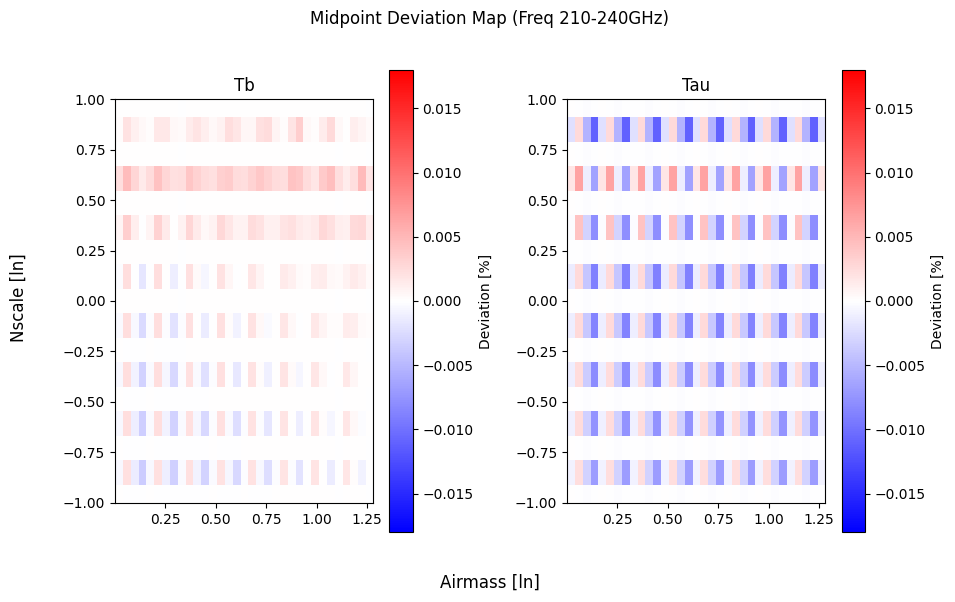

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

vmin = -0.006
vmax = 0.006
vmin = -0.018
vmax = 0.018
norm = colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1,2, figsize=(10,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

nscale_map = data['Nscale']['map']
airmass_map = data['airmass']['map']
map_extent = [map_logairmass[0], map_logairmass[-1], map_logNscale[-1], map_logNscale[0]]

for a, result in zip(ax, results_MAD):
    im = a.imshow(result, cmap='bwr', norm=norm, extent=map_extent, aspect='equal')
    fig.colorbar(im, ax=a, label='Deviation [%]')
    a.set_ylim(-1, 1)

#plt.title('Midpoint Verification Deviation Map')
fig.suptitle(f'Midpoint Deviation Map (Freq {freq_range[0]}-{freq_range[1]}GHz)')
fig.supxlabel('Airmass [ln]')
fig.supylabel('Nscale [ln]')

ax[0].set_title('Tb')
ax[1].set_title('Tau')


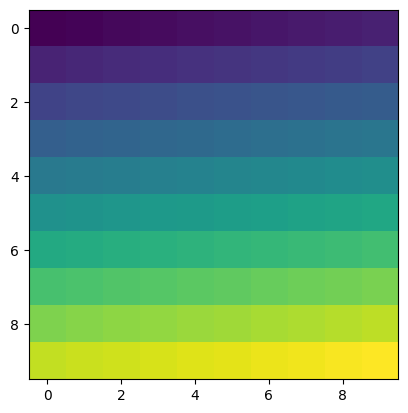

In [13]:
plt.imshow(np.arange(100).reshape(10,10))